## Import Libraries

In [1]:
import pandas as pd
import json
import numpy as np

## Load Data

In [2]:
with open('data.json', 'r') as infile:
    data = json.load(infile)
query_ids = list(data.keys())

## Compute Nr. Assessors per Query

In [3]:
counter = {}
for query_id in query_ids:
    passage_ids = list(data[query_id].keys())
    nr_assessors = int(len(data[query_id][passage_ids[0]][1:])/2)
    if not nr_assessors in counter.keys():
        counter[nr_assessors] = 1
    else:
        counter[nr_assessors] += 1
print(counter)

{1: 61, 2: 18, 3: 36, 4: 1, 5: 5, 6: 2, 7: 2}


## Create Dataframes per Query

In [4]:
def create_labels(nr_assessors):
    labels = ["query_id","passageid","msmarco"]
    for i in range(nr_assessors):
        labels = labels + ['user%s_id'%(i+1),'user%s_label'%(i+1)]
    return labels

In [5]:
dataframe_data = {}
label_data = {}
assessor_data = {}
for query_id in query_ids:
    query_list = []
    query_data = data[query_id]
    nr_assessors = 0
    for i,passage_id in enumerate(query_data.keys()):
        query_list.append([query_id, passage_id] + query_data[passage_id])
        if i == 0:
            nr_assessors = int((len(query_data[passage_id])-1)/2)
    dataframe_data[query_id] = query_list
    label_data[query_id] = create_labels(nr_assessors)
    assessor_data[query_id] = nr_assessors

In [6]:
dataframes = {}
for query_id in query_ids:
    df = pd.DataFrame(dataframe_data[query_id],columns=label_data[query_id])
    dataframes[query_id] = df

## Missing Input

Sometimes an assessors forgot to provide input, which means that the dataset includes "no_input". This is missing data and often we can fix this by considering the input of the remaining assessors. If the remaining assessors agree, I can still provide the agreed relevance label. If there is no agreement between the remaining assessors, I simply take the relevance label that MSMARCO provides.

### What queries have missing data?

In [7]:
queries_with_missing_data = []
counter = 0
for query_id in query_ids:
    nr_assessors = assessor_data[query_id]
    if nr_assessors >= 3:
        df = dataframes[query_id]
        if 'no_input' in df.values:
            counter += 1
            print(query_id)
            queries_with_missing_data.append(query_id)
print("nr of queries with missing data: %s"%(counter))


1097449
825147
993153
904389
1096257
689885
758519
202306
1077356
nr of queries with missing data: 9


### How many data is missing per query?

In [8]:
for query_id in queries_with_missing_data:
    print(query_id)
    df = dataframes[query_id]
    column_labels = list(df.columns)
    for i in range(7):
        column = 'user%s_label'%(i+1)
        if column in column_labels:
            print(column)
            print(len(df[df[column].isin(["no_input"])]))
    print("\n")

1097449
user1_label
0
user2_label
0
user3_label
0
user4_label
1
user5_label
0
user6_label
0
user7_label
0


825147
user1_label
0
user2_label
0
user3_label
1
user4_label
0
user5_label
0


993153
user1_label
0
user2_label
19
user3_label
1
user4_label
0
user5_label
0
user6_label
0
user7_label
0


904389
user1_label
0
user2_label
0
user3_label
1


1096257
user1_label
0
user2_label
1
user3_label
0


689885
user1_label
1
user2_label
0
user3_label
0


758519
user1_label
0
user2_label
1
user3_label
0


202306
user1_label
0
user2_label
1
user3_label
0


1077356
user1_label
1
user2_label
0
user3_label
0




Most queries have just one 'no_input' entry, except for query 993153 which has 19 entries. So we need to remove this query from the data and find a way to deal with the remaining queries.

In [9]:
queries_with_missing_data.remove('993153')

In [10]:
query_ids.remove('993153')

### Fix Missing Data

As we want to change the labels into binary, we want to first check if the missing data is making it impossible to go to binary. This is the case when the other assessors did provide their input but they have no agreement. In those cases we need the missing data to make a decision on the label. The other cases where the two other assessors do agree, we do not need the missing data and we can already make a decision on the final label. So lets go find those cases first and deal with the more difficult cases afterwards.

First we extract the row with the missing data and gather the assessors labels

If we then change the assessors labels to binary and there is agreement, we take the agreed label as new label. If there is no agreement, we keep the msmarco label.

In [11]:
def make_binary(label):
    if label < 3:
        return 0
    else:
        return 1

In [12]:
missing_value_fixes = {}
for query_id in queries_with_missing_data:
    df = dataframes[query_id]
    column_labels = list(df.columns)
    for i in range(7):
        column = 'user%s_label'%(i+1)
        if column in column_labels:
            if len(df[df[column].isin(["no_input"])]) > 0:
                labels = list(df[df[column].isin(["no_input"])].values[0][3:][1::2])
                labels.remove("no_input")
                binary_labels = [make_binary(int(x)) for x in labels]
                new_label = 0
                if (len(set(binary_labels))) == 1:
                    #there is agreement
                    print(query_id)
                    print("New label: %s"%(binary_labels[0]))
                    new_label = binary_labels[0]
                else:
                    msmarco_label = df[df[column].isin(["no_input"])]['msmarco'].values[0]
                    if msmarco_label == 'irrelevant':
                        print(query_id)
                        print("Label equals MSMARCO: 0")
                        new_label = 0
                    else:
                        print(query_id)
                        print("Label equals MSMARCO: 1")
                        new_label = 1
                missing_value_fixes[query_id] = {}
                missing_value_fixes[query_id]["no_input"] = new_label

1097449
New label: 1
825147
New label: 1
904389
Label equals MSMARCO: 0
1096257
New label: 0
689885
Label equals MSMARCO: 0
758519
Label equals MSMARCO: 0
202306
Label equals MSMARCO: 0
1077356
New label: 0


In [13]:
missing_value_fixes

{'1077356': {'no_input': 0},
 '1096257': {'no_input': 0},
 '1097449': {'no_input': 1},
 '202306': {'no_input': 0},
 '689885': {'no_input': 0},
 '758519': {'no_input': 0},
 '825147': {'no_input': 1},
 '904389': {'no_input': 0}}

In 2 cases where an assessor forget to give input, the passage will now be marked as relevant due to agreement between the remaining assessors.

# 3 OR MORE ASSESSORS

This section helps to change the input of the assessors into binary to get either 'irrelevant' or 'relevant'. Irrelevant is set to 0 and relevant is set to 1. All input less then 3 is set to irrelevant and all input equal to 3 or higher is set to relevant.

## Compute Binary labels

Binary: irrelevant <3; relevant >=3

In [14]:
def makeBinary(query_id,label):
    if label == "no_input":
        return missing_value_fixes[query_id][label]
    elif int(label) < 3:
        return 0
    else:
        return 1

In [15]:
for query_id in query_ids:
    nr_assessors = assessor_data[query_id]
    if nr_assessors >= 3:
        df = dataframes[query_id]
        for i in range(nr_assessors):
            df['user%s_binary_label'%(i+1)] = df[['user%s_label'%(i+1)]].apply(lambda x: [makeBinary(query_id,y) for y in x])
        dataframes[query_id] = df

## Compute Agreement

In [16]:
for query_id in query_ids:
    nr_assessors = assessor_data[query_id]
    if nr_assessors >= 3:
        df = dataframes[query_id]
        df['relevance_agreement'] = df.iloc[:, -nr_assessors:].sum(axis=1)
        df['relevant'] = df[['relevance_agreement']].apply(lambda cell: [0 if ((((nr_assessors%2) == 0) and (value < (int(np.ceil(nr_assessors/2))+1))) or (((nr_assessors%2) == 1) and (value <(int(np.ceil(nr_assessors/2)))))) else 1 for value in cell])
        dataframes[query_id] = df

# IMPORTANT NOTE

Below you will find 3 sections:
1: this section will help to compute the original assessor agreement data and save this to a .tsv file
2: this section will help to label the missing msmarco relevant passage and save this to a .tsv file
3: this section will help to create the actual data used for my thesis

Skip sections 1 and 2 to get be able to correclte create the data used for my thesis. Otherwise run section 1 before you move to section 2.

# 1. Compute Original Assessor Data

## Analyze Agreement

In [17]:
query_agreement_data = {}
for query_id in query_ids:
    nr_assessors = assessor_data[query_id]
    if nr_assessors >= 3:
        df = dataframes[query_id]
        nr_relevant = df['relevant'].sum()
        query_agreement_data[query_id] = nr_relevant

In [18]:
len(query_agreement_data)

45

In [20]:
import operator
sorted_query_agreement_data = sorted(query_agreement_data.items(), key=operator.itemgetter(1))

In [21]:
sorted_query_agreement_data

[('540906', 1),
 ('335710', 1),
 ('866251', 1),
 ('608323', 2),
 ('1091688', 2),
 ('427323', 2),
 ('1034595', 2),
 ('208494', 2),
 ('321951', 3),
 ('1056446', 4),
 ('202306', 4),
 ('904389', 4),
 ('75266', 4),
 ('54819', 4),
 ('30860', 4),
 ('1049791', 4),
 ('149161', 5),
 ('212195', 5),
 ('831784', 5),
 ('178468', 5),
 ('414155', 6),
 ('785721', 6),
 ('1040461', 7),
 ('1096257', 7),
 ('838453', 7),
 ('341317', 8),
 ('1003875', 8),
 ('689885', 8),
 ('825147', 9),
 ('1084469', 12),
 ('741392', 13),
 ('1097449', 13),
 ('1077356', 13),
 ('758519', 13),
 ('208822', 14),
 ('409143', 14),
 ('687375', 15),
 ('1006199', 16),
 ('242107', 16),
 ('440362', 16),
 ('993987', 16),
 ('1083663', 16),
 ('1007473', 18),
 ('117113', 19),
 ('1086248', 19)]

From the agreement data it can be noted that a few queries just have 1 relevant passage according to the assessors. After inspecting those queries, it is surprising to see that often these relevant passages are not the same passages appointed by MSMARCO. It is clear that the assessors do not always notice the msmarco relevant passage. This means that in order for us to work with this data we should go over all queries and check if the msmarco relevant passage is actually marked as relevant.

To be able to work with the data, I will go and check which queries have passages marked as irrelevant by assessors but are relevant according to msmarco. Those queries will be removed from the dataset.

### Save New Labels to txt 

I want to save the work of our assessors for now. So I can always decide how to work with the data. Later on I will add missing msmarco relevance labels and decide which queries we leave out of the dataset because of not enough relevance labels.

In [22]:
relevant_queries = []
relevant_passages = []
for query_id in query_ids:
    nr_assessors = assessor_data[query_id]
    if nr_assessors >= 3:
        df = dataframes[query_id]
        relevance_df = df[df['relevant'] == 1]
        relevant_queries = relevant_queries + relevance_df['query_id'].values.tolist()
        relevant_passages = relevant_passages + relevance_df['passageid'].values.tolist()
output_df = pd.DataFrame()
output_df['query_id'] = relevant_queries
output_df['label1'] = 0
output_df['passage_id'] = relevant_passages
output_df['label2'] = 1

In [23]:
output_df.to_csv('original_assessors_relevance_labels.tsv',sep='\t',index=False,header=False)

# 2. Add MSMARCO Relevance Data

### Add MSMARCO Relevant Passages (if not already included)

The code below helps to find those msmarco relevant passages and set them to relevant if the assessors did not label them as relevant. 

In [25]:
final_dataframes = {}
counter = 0
list_ids = []
for query_id in query_ids:
    nr_assessors = assessor_data[query_id]
    if nr_assessors >= 3:
        df = dataframes[query_id]
        final_df = df.copy()
        idx = final_df.index[(final_df['msmarco'] == 'relevant') & (final_df['relevant'] == 0)]
        if not (idx.values.size == 0):
            counter += 1
            list_ids.append(query_id)
            final_df.set_value(idx[0],'relevant',1)
        final_dataframes[query_id] = final_df

c:\users\tomjg\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  del sys.path[0]


In [28]:
final_query_agreement_data = {}
for query_id in query_ids:
    nr_assessors = assessor_data[query_id]
    if nr_assessors >= 3:
        df = final_dataframes[query_id]
        nr_relevant = df['relevant'].sum()
        final_query_agreement_data[query_id] = nr_relevant

In [29]:
len(query_agreement_data)

45

In [30]:
sorted_final_query_agreement_data = sorted(final_query_agreement_data.items(), key=operator.itemgetter(1))

In [31]:
sorted_final_query_agreement_data

[('335710', 1),
 ('608323', 2),
 ('1091688', 2),
 ('1034595', 2),
 ('540906', 2),
 ('866251', 2),
 ('208494', 2),
 ('427323', 3),
 ('1056446', 4),
 ('202306', 4),
 ('321951', 4),
 ('904389', 4),
 ('75266', 4),
 ('54819', 4),
 ('30860', 4),
 ('1049791', 4),
 ('149161', 5),
 ('212195', 5),
 ('831784', 5),
 ('178468', 5),
 ('414155', 6),
 ('785721', 6),
 ('1040461', 7),
 ('1096257', 7),
 ('341317', 8),
 ('838453', 8),
 ('1003875', 8),
 ('689885', 8),
 ('825147', 9),
 ('1084469', 12),
 ('741392', 13),
 ('1097449', 13),
 ('1077356', 13),
 ('758519', 13),
 ('208822', 14),
 ('409143', 14),
 ('687375', 15),
 ('1006199', 16),
 ('242107', 16),
 ('440362', 16),
 ('1083663', 16),
 ('993987', 17),
 ('1007473', 18),
 ('117113', 19),
 ('1086248', 19)]

In [32]:
import matplotlib.pyplot as plt

{'boxes': [<matplotlib.lines.Line2D at 0x226ff1135f8>],
 'caps': [<matplotlib.lines.Line2D at 0x226ff113da0>,
 'fliers': [<matplotlib.lines.Line2D at 0x226ff1267b8>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x226ff126470>],
 'whiskers': [<matplotlib.lines.Line2D at 0x226ff09f940>,
  <matplotlib.lines.Line2D at 0x226ff113a58>]}

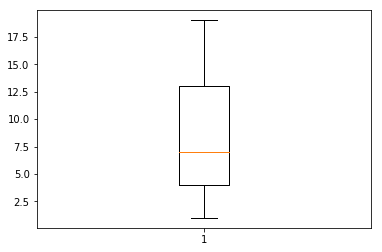

In [33]:
plt.boxplot(list(final_query_agreement_data.values()))

### Save Complete Data to tsv

After adding the msmarco relevant passages to the dataframes, query '335710' still only has 1 relevant passage. So we will need to remove this query from the dataset. The remaining queries have more than 1 relevant passage and so are of interest for our study. This means we will have 44 queries to work with.

In [34]:
query_ids.remove('335710')

In [35]:
relevant_queries = []
relevant_passages = []
for query_id in query_ids:
    nr_assessors = assessor_data[query_id]
    if nr_assessors >= 3:
        df = final_dataframes[query_id]
        relevance_df = df[df['relevant'] == 1]
        relevant_queries = relevant_queries + relevance_df['query_id'].values.tolist()
        relevant_passages = relevant_passages + relevance_df['passageid'].values.tolist()
output_df = pd.DataFrame()
output_df['query_id'] = relevant_queries
output_df['label1'] = 0
output_df['passage_id'] = relevant_passages
output_df['label2'] = 1

In [36]:
output_df.to_csv('complete_relevance_labels.tsv',sep='\t',index=False,header=False)

# 3. Create Actual Relevance Dataset

This section will help to create the dataset that is used for my thesis.

There are 6 queries for which the assessors did not label the MSMARCO relevant passage as relevant. I do not want to manually label this passage as relevant, because by doing so I am actually denying the assessments by the assessors. This is why I will remove these queries from the dataset.

#### Gather ids to remove

First gather all queries where the msmarco relevant passage is not recognized as relevant by the assessors:

In [17]:
ids_2_remove = []
for query_id in query_ids:
    nr_assessors = assessor_data[query_id]
    if nr_assessors >= 3:
        df = dataframes[query_id]
        idx = df.index[(df['msmarco'] == 'relevant') & (df['relevant'] == 0)]
        if not (idx.values.size == 0):
            ids_2_remove.append(query_id)

Then gather all queries that (when binarized and after majorith voting) have only the msmarco passage as relevant:

In [18]:
query_agreement_data = {}
for query_id in query_ids:
    nr_assessors = assessor_data[query_id]
    if nr_assessors >= 3:
        df = dataframes[query_id]
        nr_relevant = df['relevant'].sum()
        query_agreement_data[query_id] = nr_relevant

In [19]:
for query_id, nr_relevant_passages in query_agreement_data.items():
    if nr_relevant_passages < 2:
        if not query_id in ids_2_remove:
            ids_2_remove.append(query_id)

In [20]:
ids_2_remove

['866251', '427323', '838453', '540906', '993987', '321951', '335710']

In [21]:
for query_id in ids_2_remove:
    query_ids.remove(query_id)

In [25]:
relevant_queries = []
relevant_passages = []
counter = 0
for query_id in query_ids:
    nr_assessors = assessor_data[query_id]
    if nr_assessors >= 3:
        counter += 1
        df = dataframes[query_id]
        relevance_df = df[df['relevant'] == 1]
        relevant_queries = relevant_queries + relevance_df['query_id'].values.tolist()
        relevant_passages = relevant_passages + relevance_df['passageid'].values.tolist()
output_df = pd.DataFrame()
output_df['query_id'] = relevant_queries
output_df['label1'] = 0
output_df['passage_id'] = relevant_passages
output_df['label2'] = 1

In [26]:
output_df.to_csv('Multiple_Relevance_Dataset.tsv',sep='\t',index=False,header=False)